# Home Exercise on Sentiment Analysis


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gensim
import kagglehub
from gensim.models import Word2Vec
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split


### 1. Data preprocessing

Download data from kaggle using `kagglehub`

In [12]:
data_path = kagglehub.dataset_download("samantas2020/online-retail-xlsx")
print(data_path)
data_path += "\\Online Retail.xlsx"

C:\Users\ADMIN\.cache\kagglehub\datasets\samantas2020\online-retail-xlsx\versions\1


Read to dataframe `df`

In [13]:
df = pd.read_excel(data_path, engine='openpyxl')

Preprocess: Drop all rows where its `Description` column is null, lower the text and strip all extra spaces. Group the `Description` that have the same `InvoiceNo`

In [ ]:
df.dropna(subset=["Description"], inplace=True)  
df["Description"] = df["Description"].str.lower().str.strip().str.replace(r"\s+", " ", regex=True)
df_grouped = df.groupby("InvoiceNo")["Description"].apply(list)  
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,white hanging heart t-light holder,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,white metal lantern,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,cream cupid hearts coat hanger,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,knitted union flag hot water bottle,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,red woolly hottie white heart.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


Split dataset to 90% train set, 10% test set

In [ ]:
train_set, test_set = train_test_split(df_grouped, test_size=0.1, random_state=42)  # Train-test split

### 2. Build a representation model for products in the training dataset. (Model, Vocabulary and Training)

In [ ]:
model = gensim.models.Word2Vec(sentences=train_set, vector_size=100, window=5, min_count=5, workers=4)

### 3. Visualize word2vec Embeddings
Use PCA to reduce dimensionality to 2. Plot the embeddings to see clusters of similar products (firsts 100 products).


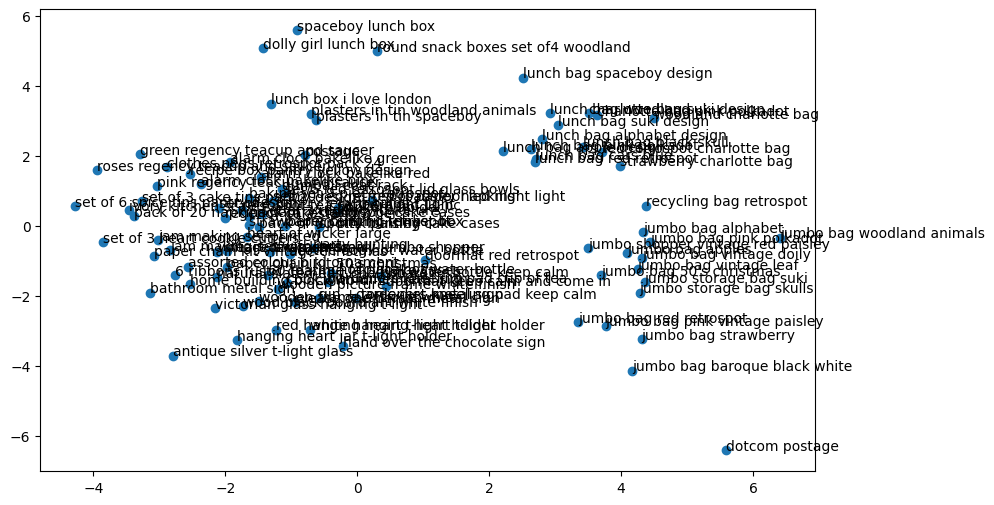

In [17]:
def plot_embeddings(model, words=100):
    vocab = list(model.wv.index_to_key)[:words]
    X = np.array([model.wv[word] for word in vocab])
    pca = PCA(n_components=2)
    result = pca.fit_transform(X)
    plt.figure(figsize=(10, 6))
    plt.scatter(result[:, 0], result[:, 1], marker='o')
    for i, word in enumerate(vocab):
        plt.annotate(word, xy=(result[i, 0], result[i, 1]))
    plt.show()

plot_embeddings(model)


### 4. Build a function to compute the similarity of products.
Use `model.wv.most_similar()` for a given product.


In [20]:
def get_similar_products(product, top_n=5):
    try:
        return model.wv.most_similar(product, topn=top_n)
    except KeyError:
        return "Product not in vocabulary"

print(get_similar_products("jumbo bag red retrospot"))


[('jumbo bag baroque black white', 0.9447650909423828), ('jumbo bag strawberry', 0.9114256501197815), ('red enchanted forest placemat', 0.7631090879440308), ('jumbo bag owls', 0.7102222442626953), ('jumbo bag pink vintage paisley', 0.7010629177093506)]


### 5. Recommend Based on Multiple Products
Compute the mean vector of a customer's previously chosen products and find nearest neighbors. Recommend items closest to this aggregated vector.


In [24]:
def recommend_based_on_history(purchased_products, top_n=5):
    vectors = [model.wv[prod] for prod in purchased_products if prod in model.wv]
    if not vectors:
        return "No valid products in vocabulary"
    mean_vector = np.mean(vectors, axis=0)
    return model.wv.similar_by_vector(mean_vector, topn=top_n)

print(recommend_based_on_history(["white metal lantern", "hand warmer red polka dot"]))


[('white metal lantern', 0.9661189913749695), ('vintage cream 3 basket cake stand', 0.8762601017951965), ('4 rose pink dinner candles', 0.8716865181922913), ('wood s/3 cabinet ant white finish', 0.8624194264411926), ('colour glass. star t-light holder', 0.8526394367218018)]
